## 【AIコース】大課題 タイタニック生存予測 ランダムフォレスト

### ●データ取得

In [103]:
import pandas as pd
import numpy as np

df_Ti = pd.read_csv('train.csv')

### ●データ確認

In [104]:
df_Ti.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [105]:
df_Ti.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


### ●sample

In [106]:
pd.DataFrame.sample(df_Ti)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
65,66,1,3,"Moubarek, Master. Gerios",male,NaN,1,1,2661,15.2458,NaN,C


In [107]:
pd.DataFrame.sample(df_Ti)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
329,330,1,1,"Hippach, Miss. Jean Gertrude",female,16.0,0,1,111361,57.9792,B18,C


In [108]:
pd.DataFrame.sample(df_Ti)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
707,708,1,1,"Calderhead, Mr. Edward Pennington",male,42.0,0,0,PC 17476,26.2875,E24,S


### ●前処理について記述せよ

A.機械学習をするに於いて、綺麗に加工されモデリングや分析のアルゴリズムを施せるデータがすぐに手に入る事はほぼあり得ない。
　コンピュータに機械学習をさせるデータとして利用するためにはそのデータを加工し分析可能なデータの型に変換する必要がある。
  その作業が前処理である。
　前処理の具体例として、生データに対して数値化や変数処理、標準化を行う。
  
  ・数値化
    機械学習の観点で言えば、コンピュータは自然言語で書かれたデータを処理する事が出来ない。
    なのでその自然言語の特徴を数値で表した特徴量に変換しなければいけない。これを数値化という。
    これによりコンピュータがその特徴量を扱えるようになる。
  
  ・変数処理
  　機械学習に於いて情報量の少ない説明変数を使用する事や、そもそも扱う説明変数の数が多い事自体が機械学習モデルの予測精度に悪影響を与える。
    それにモデルの予測結果が出た後にもその予測結果をどう解釈するかも複雑化する。
    なのでそれを解消するために情報量の少ない変数
    （例えば1000個中999個が同じ値を持ち１個だけが異なる値を持つ場合、その変数の情報量は少ない。）を削除したりする事を変数処理という。
　
 ・標準化
    データ値の範囲が大きく異なる特徴量が特徴ベクトルに含まれるとパラメータの更新がうまくいかなかったり
    値の大きな特徴量だけが結果に寄与するような予測器ができてしまう。なので適切な範囲に各特徴量のデータ値を調整する。
    こうする事でより精度の高い機械学習モデルを得ることが出来る。
    その方法を「スケーリング手法」というが、そのうちの一つの手法で実用性が高いものを標準化という。

###  ●2/前処理について記述せよ

A.先ずはデータフレームを確認して自然言語で特徴が書かれている変数はないかチェックする。
　各変数の情報量をチェックする。
  欠損値（Nan）や空白の値がないかチェックする。
　各変数のデータ値に極端に大きい値や小さい値がないかチェックする。

### ●df_Tiをdata_trainとdata_testに分ける

In [109]:
from sklearn.model_selection import train_test_split
data_train,data_test = train_test_split(df_Ti,test_size=0.3,random_state=0)

### ●前処理を行う

In [110]:
def simplify_ages(df):
    df.Age = df.Age.fillna(-0.5)
    bins = (-1, 0, 5, 12, 18, 25, 35, 60, 120)
    group_names = ['Unknown', 'Baby', 'Child', 'Teenager', 'Student', 'Young Adult', 'Adult', 'Senior']
    categories = pd.cut(df.Age, bins, labels=group_names)
    df.Age = categories
    return df

def simplify_cabins(df):
    df.Cabin = df.Cabin.fillna('N')
    df.Cabin = df.Cabin.apply(lambda x: x[0])
    return df

def simplify_fares(df):
    df.Fare = df.Fare.fillna(-0.5)
    bins = (-1, 0, 8, 15, 31, 1000)
    group_names = ['Unknown', '1_quartile', '2_quartile', '3_quartile', '4_quartile']
    categories = pd.cut(df.Fare, bins, labels=group_names)
    df.Fare = categories
    return df

def format_name(df):
    df['Lname'] = df.Name.apply(lambda x: x.split(' ')[0])
    df['NamePrefix'] = df.Name.apply(lambda x: x.split(' ')[1])
    return df    

def drop_features(df):
    return df.drop(['Ticket', 'Name', 'Embarked'], axis=1)

def transform_features(df):
    df = simplify_ages(df)
    df = simplify_cabins(df)
    df = simplify_fares(df)
    df = format_name(df)
    df = drop_features(df)
    return df

data_train = transform_features(data_train)
data_test = transform_features(data_test)
data_train.head()

/Users/takahashikoji/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/pandas/core/generic.py:2773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
/Users/takahashikoji/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/ipykernel/__main__.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/takahashikoji/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/ipykernel/__main__.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Lname,NamePrefix
857,858,1,1,male,Adult,0,0,3_quartile,E,"Daly,",Mr.
52,53,1,1,female,Adult,1,0,4_quartile,D,"Harper,",Mrs.
386,387,0,3,male,Baby,5,2,4_quartile,N,"Goodwin,",Master.
124,125,0,1,male,Adult,0,1,4_quartile,D,"White,",Mr.
578,579,0,3,female,Unknown,1,0,2_quartile,N,"Caram,",Mrs.


In [111]:
from sklearn import preprocessing
def encode_features(df_train, df_test):
    features = ['Fare', 'Cabin', 'Age', 'Sex', 'Lname', 'NamePrefix']
    df_combined = pd.concat([df_train[features], df_test[features]])

    for feature in features:
        le = preprocessing.LabelEncoder()
        le = le.fit(df_combined[feature])
        df_train[feature] = le.transform(df_train[feature])
        df_test[feature] = le.transform(df_test[feature])
    return df_train, df_test

data_train, data_test = encode_features(data_train, data_test)
data_train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Lname,NamePrefix
857,858,1,1,1,0,0,0,2,4,141,17
52,53,1,1,0,0,1,0,3,3,239,18
386,387,0,3,1,1,5,2,3,7,220,11
124,125,0,1,1,0,0,1,3,3,637,17
578,579,0,3,0,6,1,0,1,7,94,18


from sklearn import preprocessing
def encode_features(df_train, df_test):
    features = ['Fare', 'Cabin', 'Age', 'Sex', 'Lname', 'NamePrefix']
    df_combined = pd.concat([df_train[features], df_test[features]])　# pd.concat()結合する。

    for feature in features:
        le = preprocessing.LabelEncoder()　# LabelEncoderを使ってカラム内の値を数値化する。
        le = le.fit(df_combined[feature])　# 各カラムのtrainとtestを結合させたものをフィットさせている。
        df_train[feature] = le.transform(df_train[feature])　# trainの特徴量を正規化して変形させている。
        df_test[feature] = le.transform(df_test[feature]) # testの特徴量を正規化して変形させている。
    return df_train, df_test

data_train, data_test = encode_features(data_train, data_test)

### ●前処理の内容について記述せよ

__simplify_ages__
A.'Age'列の欠損値を-0.5で埋めてデータの年齢幅ごとに「group_names」の各名称に分類している。これにより'Age'列が年代別に分類される。

__simplify_cabins__
A.'Cabin'列の欠損値をNで埋めてdf.applyで各行に対して無名関数(lambda)を適用。これにより全ての'Cabin'列の全ての値が'N'になる。

__simplify_fares__
A.'Fare'列の欠損値を-0.5で埋めてデータの料金幅ごとに１〜４等船室に分類している。これにより'Fare'が客室のランクごとに分類される。

__format_name__
A.'Name'列の自然言語を元に新しい列'Lname'=0と'NamePrefix'=1を作り分類している。これにより名前が0と1の二値変数に分類される。

__drop_features__
A.説明変数として扱いにくいデータである、'Ticket', 'Name', 'Embarked'の３つの変数を削除している。これにより処理が円滑に進む。

__encode_features__
A.トレインデータ（訓練データ）とテストデータを結合させている。LabelEncoder()でfeatures内のカラムの値を数値化させている。
　data_trainとdata_testのカラムをフィット、変形させている。

### ●モデル選択について記述せよ

1.__サポートベクターマシーン(SVM)__
データを分類するための境界線を決定する際に、境界線から一番近いサンプルデータまでのマージンの和が最大になる線を境界線とする手法。
分類も回帰にも利用できる。

・長所
　1.データの特徴の次元が大きくなっても識別精度が良い
  2.最適化すべきパラメータが少ない
  3.パラメータの算出が容易

・短所
  1.モデルの汎化能力が保証されない。
  2.基本的には2クラスの分類にしか使えない
  3.学習データが増えると計算量が膨大になる
　　（「次元の呪い」の影響が顕著）
　

2.__ランダムフォレスト__
訓練データからランダムにデータを選んで決定木を複数作り、それぞれの決定木で予測された結果の多数決により、最終的なクラスを判定する手法。
回帰で使用する時は各予測の平均をとって数値を算出する。
このように、訓練データの一部を使用してモデルして予測し、それを何度も繰り返して最後に合わせる方法をバギングという。

・長所
　1.データの正規化・標準化を考える必要がない
  2.計算速度が速い
  3.特徴量をランダムに選択する事でばらつきが増えて各決定木の結果が似てしまう事が改善される


・短所
  1.複雑なデータではSVMなどの分類手法に比べて汎化性能が下がる
  2.データ数が少ないと汎化性能が下がる
  3.比較的過学習しやすい


・__Ada boost(エイダブースト)__
弱分類器を複数作り、訓練データで1番精度が高いものを第1分類器として選ぶ。
第1分類器が誤判断したデータに対して最も精度が高い分類器を第2分類器として1つ選ぶ。
これを繰り返し、弱分類器からお互いに補完しあう弱分類器を選別し、最後に合算する手法。
前回の弱分類器の結果を利用して、分類を回繰り返す方法をブースティングという。

・長所
　1.弱い識別機を幾つか組み合わせるので、精度が高く正確に分類されやすい。
  2.核となる学習アルゴリズムに何を設けるかの制限がない。
  3.少ない学習データからも効率的に学習を行う事が出来る。


・短所
  1.ノイズの多いデータや異常値に影響を受けやすい
  2.他の学習アルゴリズムと組み合わせないと効果を発揮出来ない
  3.過学習になりやすい



4.__ナイーブベイズ__
各要素(説明変数)が独立に予測対象に影響を与えていると仮定して、ベイズの定理を活用し、最もその分類が発生する確率が高いものを予測とする手法。主に文章に利用され、文章の単語をベースにした分類に使われる。

・長所
　1構築するのが簡単でパラメータ推定するために複雑な繰り返し計算が必要ない
  2.単純なだけに高速である
  3.最も古い手法であり、形も単純であるに関わらず、性能はとても高い


・短所
  1.中規模または大規模なトレーニングデータセットを持っていないと適用出来ない。
  2.インスタンスに複数の属性がないと適用出来ない。
  3.分類パラメータが与えられると、インスタンスを記述する属性は条件的に独立していなければならない。

### ●モデル選択の基準

1.「分析の目的」　　

　 この機械学習を行う上で自分は何を知りたいのか？を先ず念頭に於いてモデルを選択する。
 　例.説明変数の予測値への寄与を大雑把に知りたい。予測値の正確性が命。予測精度が実用的で因果関係の類推も行いたい。などなど

2.「中身の分かりやすさ」　　

  「中身の分かりやすさ」とは、モデルを一つの入出力器とみなした場合、
   入力に相当する説明変数と出力に相当する目的変数（予測値）間の関係が陽に解釈出来るかどうかに依存する。入出力の関係がパラメータなどを通して
   理解しやすいならばモデルはホワイトボックスとして因果類推に役立つ。
   入出力の関係性が陽でないブラックボックスなモデルの場合は如何に精度が高くとも説明変数の何がどれほど予測結果に寄与しているか言及出来ない。
   
3.「予測精度」　　

　「予測精度」 は学習から得られたモデル（近似関数）がどれだけ正確に出力するかという指標で、訓練データのみ精度が高くその他で精度が低い　　
 
  　 過学習の問題を解消出来るならば非線形性を有する手法ほど精度が高い傾向にある。　

### ●モデル選択におけるデータ可視化

In [112]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

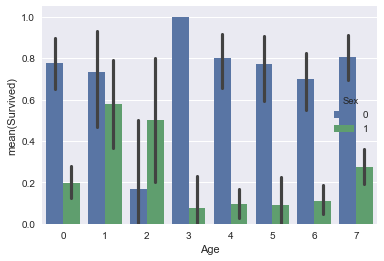

In [113]:
# hue=はSurvivedを性別毎に分けている。
sns.barplot(x="Age", y="Survived",hue="Sex", data=data_train)

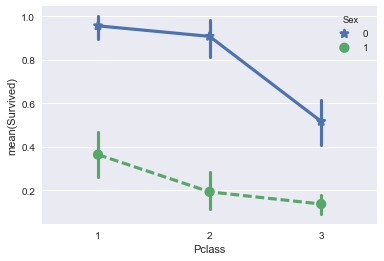

In [114]:
sns.pointplot(x="Pclass", y="Survived", hue="Sex", data=data_train,markers=["*", "o"],linestyles=["-", "--"]);

### ●データ可視化の結果について考察せよ

A.可視化する事によってデータセット内の２つの特徴量の相関度が分かりやすくなる。　　

モデル選択をする場合、先ずデータ内の気になる特徴量を可視化してそれらの相関関係を調べてみる必要がある。

### ●データセットの分割

In [115]:
from sklearn.model_selection import train_test_split

X = data_train.drop(['Survived', 'PassengerId'], axis=1)
y = data_train['Survived']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=0)

### ●ランダムフォレストについて記述せよ

A.  

__決定木__　　

決定木分析は「予測」や「判別」・「分類」を目的として使われるデータマイニング手法。顧客情報やアンケート結果などについて、【目的変数】に影響する【説明変数】を見つけ、樹木状のモデルを作成する分析方法である。
 
 __・長所__　　
 
 1.入力データから特徴を学習し、決定木と呼ばれる樹木状の構造で学習結果を視覚化でき、ルールをシンプルに表現できる特徴がある。  
 
 2.他の多くの手法ではデータの標準化 (正規化) やダミー変数の作成を必要とするのに対し決定木分析では　　
 
 このような前処理の手間がほとんど不要である。  
 
 3.カテゴリカルデータ (名義尺度の変数) と数値データ (順序尺度、間隔尺度の変数) の両方を扱うことが可能。  
 
 4.ニューラルネットなどのようなブラックボックスのモデルと比較して、  
 
 決定木はホワイトボックスのモデルだといえ、論理的に解釈することが容易である。  
 
 5.検定を行って、作成したモデルの正しさを評価することが可能である。  
 6.外れ値に対して頑健である。
 
 
 
 __・短所__  
 
 1.分類性能が高い手法ではない。（SVM）の方が良いとされる。  
 
 2.木が過度に分岐する事が多い。（過学習）学習設定や刈り込みが必要である。  
 
 3.データが少し変わるだけで全く違う木が生成される事がある。（不安定）  
 
 4.線形性の性質があるデータには適していない。  
 
 5.XOR(排他的論理和)の分類は出来ない。（２変数の同時利用が出来ない）


__ランダムフォレスト__  

訓練データからランダムにデータを選んで決定木を複数作り、それぞれの決定木で予測された結果の多数決により、最終的なクラスを判定する手法。 回帰で使用する時は各予測の平均をとって数値を算出する。 このように訓練データの一部を使用してモデルして予測し、それを何度も繰り返して最後に合わせる方法をバギングという。  

__・長所__  

1.データの正規化・標準化を考える必要がない  

2.計算速度が速い   

3.特徴量をランダムに選択する事でばらつきが増えて各決定木の結果が似てしまう事が改善される  

__・短所__  

1.複雑なデータではSVMなどの分類手法に比べて汎化性能が下がる  

2.データ数が少ないと汎化性能が下がる  

3.過学習しやすい


__今回の目的からランダムフォレストの手法が適する理由__　　

A.ランダムフォレストは「予測精度」と「中身のわかりやすさ」を両立する位置に存在し、数ある機械学習モデルの中でも使い勝手が良い。  
比較的、単純な構造で理解しやすいにも関わらず高い予測精度（汎化性能）を持ち、ホワイトボックス性があり説明変数と目的変数の因果関係を理解しやすい。なのでタイタニックの生存予測問題に於ける、生存者（目的変数）と生き残れた原因（説明変数）の関係の解釈を比較的容易に出来るから。

### ●学習

In [116]:
#ランダムフォレストを使用して、学習を行いましょう。Classifier = 分類

from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth=13,criterion='entropy',random_state=0)
clf.fit(X_train,y_train)

print(clf.score(X_train,y_train))
print(clf.score(X_test,y_test))

0.961847389558
0.784


### ●accuracyを求めよ

In [117]:
# X_test予測値
test_pred = clf.predict(X_test)
test_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 1, 0, 1])

### ●精度を確かめる

In [118]:
from sklearn.metrics import accuracy_score

print(accuracy_score(y_test,test_pred))

0.784


### ●ハイパーパラメータについて

A.コンピュータではなく人間が選択、または指定しなければいけないパラメータをハイパーパラメータ(Hyperparameter)と呼ぶ。
 
__ランダムフォレストに於けるハイパーパラメータ__  

__1.n_estimators__  
値はint。決定木の数を決定する。

__2.criterion__　　

値はstr。分割の品質を測定する機能。 測定の基準は「Gini係数」と「entropy」。

__3.max_features__  
値はint。目的変数のサンプリング時に、いくつの目的変数をサンプリングするか。

__4.max_depth__　　

値はint。ツリーの最大深度を決定する。

### ●チューニング

In [119]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=9,max_depth=13,criterion='entropy',min_samples_split=5,min_samples_leaf=1,random_state=0)
clf.fit(X_train,y_train)

print(clf.score(X_train,y_train))
print(clf.score(X_test,y_test))

0.925702811245
0.8


### ●検証について記述せよ

A.検証とは、機械学習によって得たモデルの精度を確かめる事であり、モデルの検証方法には様々ある。　　

　検証を行わないと、得られたモデルの汎化能力を確かめる事が出来ないので必ず行う必要がある。　　
 
  Accuracyとは「正解率」の事。あくまで予測結果全体と、答えがどれぐらい一致しているかを判断するひとつの指標に過ぎないので　　
  
  他の指標を使った検証を行う事でより正確にモデルの精度を確かめる事が出来る。
  
__1.交差確認法 / 一つ抜き法__　　

__2.ブートストラップ法__　　

__3.ホールドアウト法__

### ●KFoldについて記述せよ


A.K-分割交差検証では、データセットをK個に分割する。そして、そのうちの1つをtest_dataとし、残る K − 1 個をtrain_dataとするのが一般的である。交差検証は、K 個に分割されたデータセットそれぞれをテスト事例として k 回検証を行う。そうやって得られた k 回の結果を平均して1つの推定を得る。

### ●KFoldを実施する　●KFoldの結果を確認する

In [168]:
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier


kf= KFold(n_splits = 3,shuffle=True,random_state=0)
X = data_train.drop(['Survived', 'PassengerId','Lname'], axis=1)
y = data_train['Survived']
print(X.head())

a=[]
X=np.array(X)
y=np.array(y)
for train_index, test_index in kf.split(X):
    print('--')
    #print(train_index)
    #print(test_index)
    
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    clf = RandomForestClassifier(n_estimators=9,max_depth=13,criterion='entropy',min_samples_split=5,min_samples_leaf=1,random_state=0)
    clf=clf.fit(X_train,y_train)
    print(clf.score(X_train,y_train))
    b=(clf.score(X_test,y_test))
    a.append(b)
    print(clf.feature_importances_) # 各特徴量の重要度を表す。

print("KFoldによるモデルの精度{}".format(np.mean(a)))

     Pclass  Sex  Age  SibSp  Parch  Fare  Cabin  NamePrefix
857       1    1    0      0      0     2      4          17
52        1    0    0      1      0     3      3          18
386       3    1    1      5      2     3      7          11
124       1    1    0      0      1     3      3          17
578       3    0    6      1      0     1      7          18
--
0.886746987952
[ 0.15595629  0.15435843  0.13887423  0.10766132  0.04585177  0.06681461
  0.07817854  0.25230481]
--
0.903614457831
[ 0.12365441  0.17155774  0.13663523  0.11005807  0.05907109  0.10234154
  0.09426246  0.20241945]
--
0.887019230769
[ 0.08404555  0.16225889  0.14668735  0.10172588  0.07246024  0.1268486
  0.083196    0.22277748]
KFoldによるモデルの精度0.789738944630249


### ●どの特徴量が重要であったかを調査する。

A.feature_importances_の結果をもとに特徴量の重要度を確認したところ、一番数値が大きかったのは「NamePrefix」であった。　　

「NamePrefix」で性別と大人か子供かなどの情報が得られる。次に値が大きい傾向にあるのが「sex（性別）」と「 Age(年齢)」である事が確認出来た。　　

※feature_importances_に於いて数値が大きい程重要度が高いという事。